In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from utils import plot_sparsity_matrix,weight_histograms,set_all_seeds
from dataset import get_mnist_loader
import datetime

# Dataset

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))])

BATCH_SIZE = 128
EPOCHS = 20
SEED = 42
CLASSES = [0,1,2,3,4,5,6,7,8,9]
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Try to get GPU device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
set_all_seeds(SEED)

trainloader,testloader = get_mnist_loader(transform,BATCH_SIZE)

Print images from dataset and their labels

torch.Size([128, 1, 28, 28]) torch.Size([128])
1 2 8 5


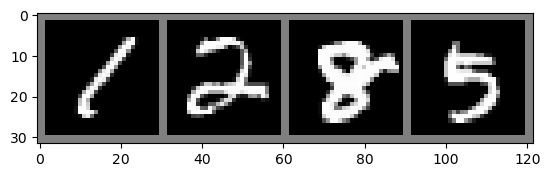

In [10]:
import matplotlib.pyplot as plt
from utils import imshow

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join(f'{labels[j]:1d}' for j in range(4)))

# LeNet-300-100

In [11]:
from models.lenet import LeNet300

net = LeNet300(10)

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

cuda:0


LeNet300(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [12]:
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as sched
from train import MyMultiStepLR

loss_fn = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=1e-3,momentum=0.9, weight_decay=1e-5)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000012CCFCC2F78>
Traceback (most recent call last):
  File "C:\Users\Dario\miniconda3\envs\pytorch\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "C:\Users\Dario\miniconda3\envs\pytorch\lib\site-packages\torch\utils\data\dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Users\Dario\miniconda3\envs\pytorch\lib\multiprocessing\process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "C:\Users\Dario\miniconda3\envs\pytorch\lib\multiprocessing\popen_spawn_win32.py", line 104, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


In [ ]:
from torch.utils.tensorboard import SummaryWriter
from train import training_loop

writer = SummaryWriter('runs/mnist/lenet-300-100/%s' % TIMESTAMP)

loss, train_acc, val_acc = training_loop(EPOCHS,net,optimizer,device,trainloader,testloader,loss_fn,100,
                                         None,'checkpoints/mnist-lenet300-100.pth',writer)



***Epoch: 001/020 | Batch:0000/0469 | Loss: 2.299
***Epoch: 001/020 | Batch:0100/0469 | Loss: 2.104
***Epoch: 001/020 | Batch:0200/0469 | Loss: 1.686
***Epoch: 001/020 | Batch:0300/0469 | Loss: 1.163
***Epoch: 001/020 | Batch:0400/0469 | Loss: 0.803
***Epoch: 001/020 | Train. Acc.: 82.003% | Loss: 0.708
Epoch: 001/020 | Train accuracy: 82.00% | Validation accuracy: 82.46% | Train loss: 0.708| Validation loss: 0.691| Best Validation (Ep. 000): -inf%
Time elapsed: 0.32 min
***Epoch: 002/020 | Batch:0000/0469 | Loss: 0.657
***Epoch: 002/020 | Batch:0100/0469 | Loss: 0.700
***Epoch: 002/020 | Batch:0200/0469 | Loss: 0.490
***Epoch: 002/020 | Batch:0300/0469 | Loss: 0.590
***Epoch: 002/020 | Batch:0400/0469 | Loss: 0.444
***Epoch: 002/020 | Train. Acc.: 87.977% | Loss: 0.437
Epoch: 002/020 | Train accuracy: 87.98% | Validation accuracy: 88.31% | Train loss: 0.437| Validation loss: 0.421| Best Validation (Ep. 001): 82.46%
Time elapsed: 0.62 min
***Epoch: 003/020 | Batch:0000/0469 | Loss: 0.5

In [ ]:
# visualization loss
plt.plot(loss)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy
plt.plot(train_acc,color = "red")
plt.plot(val_acc,color = "blue")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [ ]:
from prune import threshold_prune

s = 2
threshold_prune(net,s)

writer = SummaryWriter('runs/mnist/lenet-300-100-pruned/%s' % TIMESTAMP)

weight_histograms(writer,None,net)

torch.save(net.state_dict(), 'checkpoints/mnist-lenet300-100-pruned.pth')
plot_sparsity_matrix(net)

In [ ]:
from train import evaluate

net.load_state_dict(torch.load('checkpoints/mnist-lenet300-100-pruned.pth'))
net.to(device)

valid_acc, valid_loss = evaluate(net, testloader, device, loss_fn)

print('Accuracy after pruning: %.3f%% | Loss: %.3f' % (
        valid_acc, valid_loss))

writer = SummaryWriter('runs/mnist/lenet-300-100-retrained/%s' % TIMESTAMP)
optimizer = optim.SGD(net.parameters(), lr=1e-3,momentum=0.9,weight_decay=1e-5)


loss, train_acc, val_acc = training_loop(EPOCHS,net,optimizer,device,trainloader,testloader,loss_fn,100,
                                         None,'checkpoints/mnist_lenet300_retrained.pth',writer)

plot_sparsity_matrix(net)

# LeNet-5

Images need to be rescaled to size 32x32 as described in LeCun et al. 1998

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5)),
     transforms.Resize(32)])
# Load datasets
trainloader,testloader = get_mnist_loader(transform,BATCH_SIZE)

In [ ]:
import matplotlib.pyplot as plt

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join(f'{labels[j]:1d}' for j in range(4)))

In [ ]:
from models.lenet import LeNet5

net = LeNet5(10)
# Try to get GPU device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

In [ ]:
from train import training_loop

loss_fn = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=1e-3,momentum=0.9,weight_decay=1e-5)

lrs = MyMultiStepLR({0:5e-4,2:2e-4,5:1e-4,8:5e-5,12:1e-5})
# scheduler = sched.LambdaLR(optimizer,  lrs.get_lr,last_epoch=-1,verbose=True)

writer = SummaryWriter('runs/mnist_lenet-5/%s' % TIMESTAMP)

loss, train_acc, val_acc = training_loop(EPOCHS,net,optimizer,device,trainloader,testloader,loss_fn,100,None
                                         ,'checkpoints/mnist_lenet5.pth',writer)

In [ ]:
# visualization loss
plt.plot(loss)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy
plt.plot(train_acc,color = "red")
plt.plot(val_acc,color = "blue")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [ ]:
net = LeNet5(10)
net.load_state_dict(torch.load('checkpoints/mnist_lenet5.pth'))
net.to(device)

s = 1
threshold_prune(net,s)

writer = SummaryWriter('runs/mnist/lenet5-pruned/%s' % TIMESTAMP)

weight_histograms(writer,None,net)
torch.save(net.state_dict(), 'checkpoints/mnist_lenet5_pruned.pth')

valid_acc, valid_loss = evaluate(net, testloader, device, loss_fn)

print('Accuracy after pruning: %.3f%% | Loss: %.3f' % (
        valid_acc, valid_loss))

optimizer = optim.SGD(net.parameters(), lr=1e-3,momentum=0.9,weight_decay=1e-5)
writer = SummaryWriter('runs/mnist/lenet5-retrained/%s' % TIMESTAMP)

loss, train_acc, val_acc = training_loop(EPOCHS,net,optimizer,device,trainloader,testloader,loss_fn,100,
                                         None,'checkpoints/mnist_lenet5_retrained.pth',writer)